# ETAN Budget

In [50]:
from dask.distributed import Client

client = Client("tcp://10.32.2.180:45343")
client

Client Scheduler: tcp://10.32.2.180:45343 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 30 Cores: 60 Memory: 345.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

In [4]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
#rename time (and iter axis)
dt = dt.rename({'time_snp':'time'})
# time axis of dt should be the same as of the monthly averages
dt.time.values = ds.time[1:-1].values
#dt.time.values = ds.time.values[1:-1] 
#add nans to dt to change size form 286 to 288

ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

#should I just add nans as first and last value?

In [5]:
ds_ll = faces_dataset_to_latlon(ds)
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])

In [6]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=100, i_g=100)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=100, i_g=100)
ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: i, i_g, j, j_g
Data variables:
    ADVr_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ETAN       (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    ETAN_snp   (time_snp, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    GEOFLX     (j, i) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
    SALT       (time, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    SALT_snp   (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    SFLUX      (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    TFLUX      (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    THETA      (time, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    THETA_snp  (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    WVELMASS   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    oceFWflx   (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    oceQsw     (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    oceSPtnd   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVx_SLT   (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVy_SLT   (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    ADVx_TH    (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVy_TH    (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    DFxE_SLT   (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFyE_SLT   (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    DFxE_TH    (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFyE_TH    (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    UVELMASS   (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    VVELMASS   (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>

$$
\int_{\partial V} \frac{d (ETAN_{snp})}{dt}\ dA
$$

In [7]:
lower_lat = 35 #9
upper_lat = 75 #44
left_lon = 75 #21
right_lon = 167 #120

In [8]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

In [35]:
deta_dt = ds.ETAN_snp.diff(dim='time_snp') / (ds.time_snp.diff(dim='time_snp').astype('f')/1e9)
deta_dt

<xarray.DataArray (time_snp: 286, j: 270, i: 360)>
dask.array<truediv, shape=(286, 270, 360), dtype=float32, chunksize=(1, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
Dimensions without coordinates: j, i

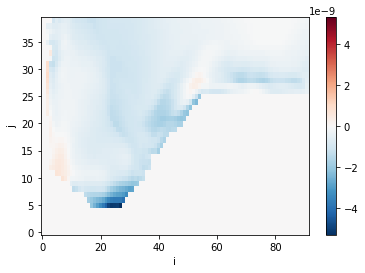

In [43]:
deta_dt.isel(**lat_range, **lon_range).mean(dim='time_snp').plot()

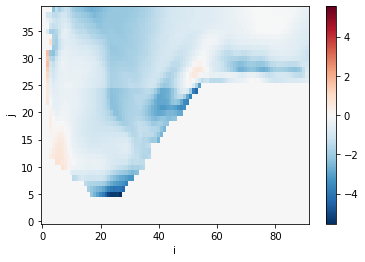

In [46]:
(deta_dt * coords.rA).isel(**lat_range, **lon_range).mean(dim='time_snp').plot()

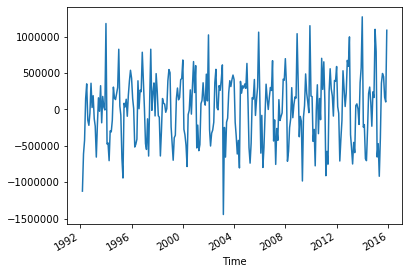

In [51]:
(deta_dt * coords.rA).sum(dim=['i', 'j']).plot() #[m^3/s]

In [55]:
t = (deta_dt * coords.rA).sum(dim=['i', 'j']).mean('time_snp')
t.load() #0.021Sv added to region

<xarray.DataArray ()>
array(21002.26, dtype=float32)